# Demonstration: Complex-Valued Affine Coupling Layer

This notebook is meant to show how the affine coupling layer - with complex-valued trainable parameters - works.
To show a typical show case, the next lines of code implement the 2-site Hubbard model. 
For more information about the methods referr to [our paper](https://arxiv.org/abs/2203.00390).

In [1]:
# Everything is set up to work in torch to make interfacing with the neural network easier
import torch

# plotting is done using matplotlib 
import matplotlib.pyplot as plt

# matplotlib works better with numpy.
import numpy as np

# For fitting wie simply use
from scipy.optimize import curve_fit

# Easier looping
import itertools as it


# The Layers are implemented using torch.nn.Module:
# Implementation the Paired (Random) Coupling Layer (PRCL)
from layer import PRCL
# Implementation of the Affine Coupling
from layer import AffineCoupling

# The Layers are set up to calculate the log det on the fly. 
# This requires a special implementation of the sequential container
from layer import Sequential

In [2]:
# the code is absolutely not optimized for GPU nor could the 
# 2 site problem fill a GPU thus it might be best to keep it 
# with device = 'cpu'.
torchTensorArgs = {
    "device": torch.device('cpu'),
    "dtype" : torch.cdouble
}

## Simulation parameters

The following cell defines the parameter of the Hubbard model. 

In [3]:
### Number of time slices
Nt   = 4

# Controle the continuum limit with
beta = 1

# On site interaction
U    = 1

# chemical potential
mu   = 1

# lattice spacing
delta= beta/Nt

# Put to 0 if not desired:
# tangent plane 
tpOffset = -6.97420945e-02 # Nt=4,beta=U=mu=1
# tpOffset = 0

In [4]:
# Don't change anything in this cell! 
# It provides named variables to increase readability of the code

# number of ions in the lattice
Nx = 2

# Make all variables unit less
U  = delta * U
mu = delta * mu

# hopping matrix (particles)
# exp( \kappa + C^p )
expKappa_p = torch.zeros((Nx, Nx),**torchTensorArgs)
expKappa_p[0, 0] = np.cosh(delta) * np.exp(mu)
expKappa_p[0, 1] = np.sinh(delta) * np.exp(mu)
expKappa_p[1, 0] = np.sinh(delta) * np.exp(mu)
expKappa_p[1, 1] = np.cosh(delta) * np.exp(mu)

# hopping matrix (holes)
# exp( \kappa + C^h )
expKappa_h = torch.zeros((Nx, Nx),**torchTensorArgs)
expKappa_h[0, 0] =  np.cosh(delta) * np.exp(-mu)
expKappa_h[0, 1] = -np.sinh(delta) * np.exp(-mu)
expKappa_h[1, 0] = -np.sinh(delta) * np.exp(-mu)
expKappa_h[1, 1] =  np.cosh(delta) * np.exp(-mu)

In [5]:
def M(phi,species):
    r"""
        \params:
            - phi: torch.tensor(Nt,Nx), configuration
            - species: +1 for particles, -1 for holes
        
        M(phi)_{t',x'; t,x} = \delta_{t',t} \delta_{x',x} - exp(s*(\Kappa+\mu))_{x',x} exp(i*s*\Phi_{t,x}) \delta_{t',t+1} 
    """
    Nt,Nx = phi.shape
    
    M = torch.zeros((Nt, Nx, Nt, Nx), **torchTensorArgs)
    
    # determine the expression of exp(s*Kappa) from the species 
    if species == 1:
        expKappa = expKappa_p
    elif species == -1:
        expKappa = expKappa_h
    else:
        return ValueError(f"Fermion Matrix got wrong species argument. Must be +/- 1 but is {species}.")
    
    # precompute the exponential of the configuration
    
    expphi = torch.exp(species*1.j*phi)
    
    ts = torch.arange(0,Nt-1)
    M[ts,:,ts,:] = torch.eye(Nx,**torchTensorArgs)
    
    M[ts+1, :, ts, :] = -expKappa[:, :] * expphi[ts,None, :]
    # bulk time slices
    #for t in range(Nt - 1):
        # \delta_{t',t} \delta_{x',x}
       
    
    # \delta_{t',t} \delta_{x',x}
    M[Nt - 1, :, Nt - 1, :] = torch.eye(Nx,**torchTensorArgs)
    
    # bundary time slice 
    # term t' = Nt = 0,  t = Nt-1
        # exp(s*(\Kappa+\mu))_{x',x} exp(i*s*\Phi_{t,x}) \delta_{t',t+1}
    
    M[0, :, Nt-1, :] = expKappa[:, :] * expphi[Nt-1,None, :]

    return M

In [6]:
# to define the action we will need the log det of the matrices
def logdetM(phi,species):    
    r"""
        \params:
            - phi: torch.tensor(Nt,Nx), configuration
            - species: +1 for particles, -1 for holes
        
        \log \det [M(phi)_{t',x'; t,x}] 
    """
    # For torch to handle M as a matrix we can simply reshape the 4 rank tensor to a 2 rank tensor (i.e. matrix)
    return torch.log(torch.linalg.det(M(phi,species).reshape(Nt*Nx,Nt*Nx)))

In [7]:
# the action of the system
def action(phi):
    r"""
        \params:
            - phi: torch.tensor(Nt,Nx), configuration
            - species: +1 for particles, -1 for holes
        
        S(\phi) = \frac{1}{2U} \phi^T \phi - \log{\det{ M^p \cdot M^h }}   
    """
    return (phi*phi).sum()/(2*U) - logdetM(phi,+1) - logdetM(phi,-1) 

In [8]:
# generalized MD hamiltonian
def hamiltonian(phi,pi):
    r"""
        \params:
            - phi: torch.tensor(Nt,Nx), configuration
            - species: +1 for particles, -1 for holes
        
        H(\phi) = \frac{1}{2} \pi^T \pi + S(\phi)   
    """

    return 0.5*(pi*pi).sum() + action(phi)

In [9]:
# The force term from log det M^p
def TrMinvM(phi,species):
    r"""
        \params:
            - phi: torch.tensor(Nt,Nx), configuration
            - species: +1 for particles, -1 for holes
        
        \frac{d \log{\det{ M(\phi) }}}{ d\phi } = \Tr{ M^{-1}(\phi) \cdot \frac{dM(\phi)}{d\phi} }
        
        where 
        
        \frac{dM(\phi)_{t',x'; t,x}} }{d\phi_{t,x}} = -i*s* exp(s*(\Kappa+\mu))_{x',x} exp(i*s*\phi_{t,x}) \delta_{t',t+1} 
    """
    # Tr = d logdetM(\phi)/d\phi_{t,x}
    Tr = torch.zeros((Nt,Nx),**torchTensorArgs)
    
    # determine the expression of exp(s*Kappa) from the species 
    if species == 1:
        expKappa = expKappa_p
    elif species == -1:
        expKappa = expKappa_h
    else:
        return ValueError(f"Force got wrong species argument. Must be +/- 1 but is {species}.")
    
    expphi = torch.exp(species*1j*phi)
    
    # again reshape M for torch to understand it as a matrix
    Minv = torch.linalg.inv(
        M(phi,species).reshape(Nt * Nx, Nt * Nx)
    ).reshape(Nt, Nx, Nt, Nx)
    
    ts = torch.arange(0,Nt-1)
    
    #bulk time slices
    #for t in range(Nt-1): 
        #for x in range(Nx):
            # temp_{t,x} = sum_{t'} M^{-1}_{t,x; t',x'} exp(s*(\Kappa+\mu))_{x',x} \delta_{t',t+1}
            # This is the matrix multiplication with y=x'
            # The sum over t' is resolved with the delta_{t',t+1}
        
    temp = torch.diagonal(torch.tensordot(Minv[ts,:,ts+1,:],expKappa[:,:],dims=1), dim1 = 1, dim2 = -1)
        
        #print(temp)    
            # (TrMinvM)_{t,x} = -i * s * temp_{t,x} * exp(i*s*\phi_{t,x})
    Tr[ts, :] = -1.j * species * temp[:] * expphi[ts, :]
    
    # boundary time slice
    # term t = Nt=0, t' = Nt=-1 
    #for x in range(Nx):
        # temp_{Nt-1,x} = M^{-1}_{0,x; t'=0,x'} exp(s*(\Kappa+\mu))_{x',x} \delta_{t'=0,t+1}tmp_{t,x} 
        #               = M^{-1}_{t,x,t+1} @ exp(Kappa) 
    temp = torch.diag(torch.tensordot(Minv[Nt-1,:,0,:],expKappa[:,:],dims=1))
    # (TrMinvM)_{Nt-1,x} = i * s * tmp_{t,x} * exp(i*s*phi_{t,x})
    Tr[Nt - 1, :] = 1.j * species * temp * expphi[Nt-1, :]

    return Tr

In [10]:
def TrMinvM_ph(phi):
    r"""
        \params:
            - phi: torch.tensor(Nt,Nx), configuration
        
         Compute the fermionic part of the force (see TrMinvM) for both species
    """
    return TrMinvM(phi,+1) + TrMinvM(phi,-1)

In [11]:
def force(phi):
    r"""
        \params:
            - phi: torch.tensor(Nt,Nx), configuration
            
        F(phi) = - dS(phi)/dphi = - d/dphi ( 1/2U phi^2 - log det M^p - log det M^h )
                                = - [ 1/U phi - Tr( M^{p,-1} dM^p/dphi + M^{h,-1} dM^h/dphi ) ]
    """
    
    return -(phi/U - TrMinvM_ph(phi))

In [12]:
testForce = True
if testForce:
    succeed = True
    epsilon = 1e-4
    
    phi = torch.randn((Nt,Nx),**torchTensorArgs).real + 1j*tpOffset
    
    forceValue = force(phi)
    
    S = action(phi)
    
    for t,x in it.product(range(Nt),range(Nx)):
        phiPeps = phi.clone()
        phiPeps[t,x]+=epsilon
        
        SPeps = action(phiPeps)
        
        dS = (SPeps - S)/epsilon
        
        # force = -dS/dPhi
        Re_err = torch.abs(dS.real+forceValue[t,x].real).item()
        Im_err = torch.abs(dS.imag+forceValue[t,x].imag).item()
        err    = torch.abs(dS+forceValue[t,x]).item()
        
        if Re_err >= epsilon*10:
            print(f"Re Force error[{t=},{x=}] = {Re_err:.1e} > {epsilon:.0e}")
            succeed = False
        if Im_err >= epsilon*10:
            print(f"Im Force error[{t=},{x=}] = {Im_err:.1e} > {epsilon:.0e}")
            succeed = False
        if err >= epsilon*10:
            print(f"Abs Force error[{t=},{x=}]= {err:.1e} > {epsilon:.0e}")
            succeed = False
            
    if succeed:
        print(f"Force test succeeded without error")

Force test succeeded without error


In [13]:
def leapfrog(phi0,pi0,trajLength,Nmd,direction = 1):
    r"""
        \params:
            - phi0: torch.tensor(Nt,Nx), start configuration 
            - pi0 : torch.tensor(Nt,Nx), momentum field (complex dtype but with vanishing imaginary part)
            - trajLength: float, trajectory length i.e. time to which the eom are integrated
            - Nmd : int, number of molecular dynamics steps 
            - direction: int, direction (+/-) in which the algorithm should integrade
            
        This function integrades the Hamilton Equation of Motion (see hamiltonian and force) using the 
        leapfrog algorithm.
        
        This algorithm is reversible up to numerical precision and energy preserving up to order epsilon^2 where
        epsilon = trajLength/Nmd
    """
    # deepcopy the fields to not change the original torch tensors
    phi = phi0.clone()
    pi = pi0.clone()
    
    # compute the step size and specify the integration direction 
    stepSize = direction*trajLength/Nmd 
    
    # first half step
    # x_{1/2} = x_{0} + 0.5*\Delta t * p_{0}
    phi+= 0.5 * stepSize * pi
    
    # a bunch of full steps
    # p_{t+1} = p_{t} + \Delta t Re(dS/dphi)
    # x_{t+3/2} = x_{t+1/2} + \Delta t * p_{t+1}
    for _ in range(Nmd-1):
        pi += stepSize * force(phi).real
        phi+= stepSize * pi
    
    # final half step
    # p_{Nmd-1} = p_{Nmd-2} + \Delta t Re(dS/dphi)
    # x_{Nmd-1} = x_{Nmd-3/2} + 0.5 \Delta t * p_{Nmd-1}
    pi += stepSize * force(phi).real
    phi+= 0.5 * stepSize * pi
    
    return phi,pi

In [14]:
%%time

# set True to execute test, set False to skip test
testLeapfrog = False

if testLeapfrog:
    # define test parameter 
    trajLengthList = torch.tensor([1])
    NmdList = torch.arange(0,101,10)[1:]
    
    print(f"Testing with:\n"
         +f"\t * Trajectory lengths: {list(trajLengthList.numpy())}\n"
         +f"\t * N_MD: {list(NmdList.numpy())}\n",
          end = ""
    )
    
    # free theory:
    #phi_s = torch.zeros((Nt,Nx),**torchTensorArgs) 
    # interacting theory:
    phi_s = torch.randn((Nt,Nx),**torchTensorArgs).real + 1j*tpOffset
    # pi_s is of complex dtype but need to be real. 
    # As torchTensorArgs specifies makes the tensor complex (at least it should ;) 
    # randn will sample a real and imaginary part 
    # this means we need to take the real part and add a zero imaginary part again
    pi_s  = torch.randn((Nt,Nx),**torchTensorArgs).real + 0j
    
    H0 = hamiltonian(phi_s,pi_s)
    
    reversibility_error = torch.zeros( size=(len(trajLengthList),len(NmdList)) )
    energyConservation_error = torch.zeros( size=(len(trajLengthList),len(NmdList)) )
    
    for (tlID,trajLength),(NmdID,Nmd) in it.product(enumerate(trajLengthList),enumerate(NmdList)):
        # forward
        phi_lf,pi_lf = leapfrog(
            phi0 = phi_s,
            pi0  = pi_s ,
            trajLength = trajLength,
            Nmd    = Nmd,
            direction = 1
        )
        
        # backward
        phi_e,pi_e = leapfrog(
            phi0 = phi_lf,
            pi0  = pi_lf ,
            trajLength = trajLength,
            Nmd    = Nmd,
            direction = -1
        )
        
        reversibility_error[tlID,NmdID] = (phi_s-phi_e).sum().abs() + (pi_s-pi_e).sum().abs()
        energyConservation_error[tlID,NmdID] = ((hamiltonian(phi_lf,pi_lf)-H0).real/H0.real).abs()

Wall time: 0 ns


In [15]:
if testLeapfrog:
    # plotting Reversibility Error: Expected is zero within some round of errors
    for tlID,trajLength in enumerate(trajLengthList):
        plt.plot(NmdList, reversibility_error[tlID,:],'x', label = f"Trajectory Length: {trajLength}")
    plt.xlabel(r"$N_{MD}$")
    plt.ylabel(r"$||\Phi_s-\Phi_e||+||\pi_s-\pi_e||$")
    plt.legend()

In [16]:
if testLeapfrog:    
    # plotting Energy Conservation Error: Expected is square dependency with trajectoryLength/Nmd
    print(f"Best Fit Results: A x² + B")
    for tlID,trajLength in enumerate(trajLengthList):
        plt.plot(trajLength/NmdList, energyConservation_error[tlID,:],'x:', label = f"Trajectory Length L={trajLength}")
        popt,_ = curve_fit(
            f = lambda x,A,B: A*x**2+B,
            xdata = (trajLength/NmdList).numpy(),
            ydata = energyConservation_error[tlID,:].numpy()
        )
        popt,pcov = curve_fit(
            f = lambda x,A,B: A*x**2+B,
            xdata = (trajLength/NmdList).numpy(),
            ydata = energyConservation_error[tlID,:].numpy(),
            p0 = popt
        )
        abscissa = np.linspace(0, trajLength/torch.min(NmdList).item(),1000 )
        ordinate = popt[0] * abscissa**2 + popt[1]
        plt.plot(abscissa,ordinate,label = rf"Best Fit(L={trajLength}): $A x^2 + B$")
        print(f"* L = {trajLength}: \n"
            + f"\t A = {popt[0]: .2e} \u00b1 {np.sqrt(pcov[0,0]):.2e}\n"
            + f"\t B = {popt[1]: .2e} \u00b1 {np.sqrt(pcov[1,1]):.2e}"
        )
        
    plt.xlabel(r"$\varepsilon = \frac{L}{N_{MD}}$")
    plt.ylabel(r"$\left\vert\Re{\frac{H_L - H_0}{H_0}}\right\vert$")
    plt.legend()

In [17]:
def HMC(phi0, trajLength, Nmd, Nconf, burnIn, thermalization):
    r"""
        \params:
            - phi0:           torch.Tensor(Nt,Nx), start element of the markov chain
            - trajLength:     float, Molecular Dynamics integration length, see leapfrog
            - Nmd:            int,  number of integration steps, see leapfrog
            - Nconf:          int, number of configurations (after burn in and without thermalization)
            - burnIn:         int, number of configurations to be discarded at the beginning of the algorithm (thermalization from phi0)
            - thermalization: int, number of configurations to be discarded between two markov elements (reducing the autocorrelation)
    
        Implementation of a HMC algorithm.
    """
    
    def hmc_step(phi_n):
        r"""
            A HMC step if transformation is None!
        """
        
        # sample a momentum field pi ~ N(0,1)
        pi = torch.normal(
            mean = torch.zeros((Nt,Nx),**torchTensorArgs).real, 
            std  = torch.ones((Nt,Nx),**torchTensorArgs).real
        ) + 0.j
        
        # Compute initial hamiltonian value
        H0 = hamiltonian(phi_n,pi)
        
        # Integrate Hamiltons EoM to generate a proposal
        phi,pi = leapfrog(
            phi0 = phi_n,
            pi0  = pi ,
            trajLength = trajLength,
            Nmd    = Nmd,
        )
        
        # Compute final hamiltonian value
        H1 = hamiltonian(phi,pi)
        
        
        # accept reject
        if torch.rand(1).item() <= torch.exp( -(H1-H0).real ).item():
            return phi, 1
        else:
            return phi_n, 0
        
        # Compute final hamiltonian value
        H1 = hamiltonian(phi,pi)
        
        # accept reject
        if torch.rand(1).item() <= torch.exp( -(H1-H0).real ).item():
            return phi, 1
        else:
            return phi_n, 0
    
    # create a list of configurations with length Nconf
    markovChain = torch.zeros( (Nconf,Nt,Nx), **torchTensorArgs )
    
    # create a list of action values
    action_full = torch.zeros( (Nconf+burnIn), **torchTensorArgs )
    action_markovChain = torch.zeros( (Nconf), **torchTensorArgs )
    
    # perform burnIn calculations
    phi_n = phi0.clone()
    for n in range(burnIn):
        phi_n,_ = hmc_step(phi_n)
        action_full[n] = action(phi_n)

    # store starting point of HMC
    markovChain[0,:,:] = phi_n
    action_markovChain[0] = action(markovChain[0])
    
    acceptenceRate = 0
            
    # perform markov chain calculation
    for n in range(Nconf-1):
        markovChain[n+1],acceptence = hmc_step(markovChain[n])
        action_full[n+burnIn] = action(markovChain[n+1])
        action_markovChain[n+1] = action_full[n+burnIn]
            
        acceptenceRate += acceptence
        
        if n != Nconf-2:
            # intermediate thermalization
            phi_n = markovChain[n+1]
            for _ in range(thermalization):
                phi_n,_ = hmc_step(phi_n)
        
    
    return {
        "configs": markovChain,
        "S": action_markovChain,
        "S full": action_full,
        "acceptence rate": acceptenceRate/Nconf
    }

In [18]:

%%time

testHMC = False

if testHMC:
    trajectoryLength = 1.5
    N_moleculardynamics = 3
    Nconf = 2_000
    burnIn = 1_000
    thermalization = 0

    # And here is how it works without a Neural Network:
    res = HMC(
        phi0 = torch.rand(Nt,Nx,**torchTensorArgs).real+1.j*tpOffset, 
        trajLength = trajectoryLength, 
        Nmd = N_moleculardynamics, 
        Nconf = Nconf, 
        burnIn = burnIn, 
        thermalization = thermalization
    )


Wall time: 0 ns


In [19]:
testHMC = False

if testHMC:
    # plot the action evolution
    plt.plot(np.arange(0,burnIn+Nconf), res['S full'].real.numpy(), 'x', label = r"$S[\phi_n]$")
    S_est = np.ones(burnIn+Nconf)*res['S'].real.mean().item()
    S_err = np.ones(burnIn+Nconf)*res['S'].real.std().item()
    plt.plot( np.arange(0,burnIn+Nconf), S_est, 'r-', label = r"$\left\langleS[\phi_n]\right\rangle$" )
    plt.fill_between(np.arange(0,burnIn+Nconf),
        S_est-S_err,
        S_est+S_err,
        color = 'r',
        alpha = 0.4
    )
    plt.axvline(burnIn, color='k',linestyle ='-.', label = "Burn In")

    plt.xlabel(r"Markov Chain ID: $n$")
    plt.ylabel(r"Action Value: $S[\phi_n]$")
    plt.legend()
    plt.title(f"Action Evolution with burnIn={burnIn}")

    print(f"Acceptence Rate = {res['acceptence rate']}")


In [20]:
def MLHMC(phiR0, trajLength, Nmd, Nconf, burnIn, transformation, thermalization):
    r"""
        \params:
            - phi0:           torch.Tensor(Nt,Nx), start element of the markov chain
            - trajLength:     float, Molecular Dynamics integration length, see leapfrog
            - Nmd:            int,  number of integration steps, see leapfrog
            - Nconf:          int, number of configurations (after burn in and without thermalization)
            - burnIn:         int, number of configurations to be discarded at the beginning of the algorithm (thermalization from phi0)
            - transformation: torch.nn.Module, network trained to move the configuration to a sign problem reduced manifold
            - thermalization: int, number of configurations to be discarded between two markov elements (reducing the autocorrelation)
    
        Implementation of a HMC algorithm, augmented with machine learning to alleviate the sign problem.
    """
    
    def hmc_step(phiM_n, phiR_n, logDetJ_NN_n):
        
        # sample a momentum field pi ~ N(0,1)
        pi = torch.normal(
            mean = torch.zeros((Nt,Nx),**torchTensorArgs).real, 
            std  = torch.ones((Nt,Nx),**torchTensorArgs).real
        ) + 0.j
        
        # Compute initial hamiltonian value
        S0 = action(phiM_n)
        H0 = S0 + 0.5*(pi*pi).sum() - logDetJ_NN_n
        
        # Integrate Hamiltons EoM to generate a proposal
        # This integration needs to be done on the real plane!
        phiR,pi = leapfrog(
            phi0 = phiR_n,
            pi0  = pi,
            trajLength = trajLength,
            Nmd    = Nmd,
        )
        
        # transform to the more optimal manifold
        phiM, logDetJ_NN = transformation(phiR)
        
        # Compute final hamiltonian value
        S1 = action(phiM)
        H1 = S1 + 0.5*(pi*pi).sum() - logDetJ_NN
        
        # WHY DOES THE MOMENTUM FIELD REMAIN UNCHANGED?
        
        #print("the probability to accept is ", torch.exp( -(H1-H0).real ))

        
        # accept reject
        if torch.rand(1).item() <= torch.exp( -(H1-H0).real ).item():
            return phiM,phiR,logDetJ_NN, S1, 1
        else:
            return phiM_n,phiR_n,logDetJ_NN_n, S0, 0
    
    # create a list of configurations with length Nconf
    # manifold configs
    markovChainM = torch.zeros( (Nconf,Nt,Nx), **torchTensorArgs )
    # real plane configs
    markovChainR = torch.zeros( (Nconf,Nt,Nx), **torchTensorArgs )
    
    # create a list of action values
    action_full = torch.zeros( (Nconf+burnIn), **torchTensorArgs )
    action_markovChain = torch.zeros( (Nconf), **torchTensorArgs )
    
    # create a list of weights i.e. logDet J_NN
    logDetJ_NN_full = torch.zeros( (Nconf+burnIn), **torchTensorArgs )
    logDetJ_NN_markovChain = torch.zeros( (Nconf), **torchTensorArgs )
    
    # perform burnIn calculations
    phiR_n = phiR0.clone()
    phiM_n, logDetJ_NN_n = transformation(phiR_n)
    for n in range(burnIn):
        phiM_n,phiR_n,logDetJ_NN_n,S_n,_ = hmc_step(phiM_n,phiR_n,logDetJ_NN_n)
        action_full[n] = S_n
        #print(logDetJ_NN_n)
        logDetJ_NN_full[n] = logDetJ_NN_n

    # store starting point of HMC
    markovChainM[0,:,:] = phiM_n
    markovChainR[0,:,:] = phiR_n
    action_markovChain[0] = action_full[burnIn-1]
    logDetJ_NN_markovChain[0] = logDetJ_NN_full[burnIn-1]
    
    acceptenceRate = 0
    
    logDetJ_NN_n = logDetJ_NN_markovChain[0] 
            
    # perform markov chain calculation
    for n in range(Nconf-1):
        markovChainM[n+1],markovChainR[n+1],logDetJ_NN_markovChain[n+1],action_markovChain[n],acceptence = \
            hmc_step(phiM_n,phiR_n,logDetJ_NN_n)
        
        action_full[n+burnIn] = action_markovChain[n]
        logDetJ_NN_full[n+burnIn] = logDetJ_NN_markovChain[n+1]
        
            
        acceptenceRate += acceptence
        
        phiM_n = markovChainM[n+1]
        phiR_n = markovChainR[n+1]
        logDetJ_NN_n = logDetJ_NN_markovChain[n+1]
        if n != Nconf-2:
            for _ in range(thermalization):
                phiM_n,phiR_n,logDetJ_NN_n,S_n,_ = hmc_step(phiM_n,phiR_n,logDetJ_NN_n)
        
    return {
        "configsM": markovChainM,
        "configsR": markovChainR,
        "S": action_markovChain,
        "S full": action_full,
        "log Det J_NN": logDetJ_NN_markovChain,
        "log Det J_NN full": logDetJ_NN_full,
        "acceptence rate": acceptenceRate/Nconf
    }

In [21]:
class LinearTransformation(torch.nn.Module):
    def __init__(self, Nt, Nx):
        super(LinearTransformation, self).__init__()
        self.register_parameter(name='bias', param=torch.nn.Parameter(torch.zeros((Nt, Nx//2), **torchTensorArgs)))
        self.register_parameter(name='weight', param=torch.nn.Parameter(torch.zeros((Nt, Nx//2, Nt, Nx//2), **torchTensorArgs)))

    def forward(self, x):
        
        
        return torch.tensordot(x,self.weight,dims=([-1,-2],[0,1])) + self.bias
        

In [22]:
# define a random PRACL layer to test the transformation
def generate_parameters(internalLayer):
    
    layer = []
    for _ in range(internalLayer-1):
        
        
        d = LinearTransformation(Nt, Nx)
        
        layer.append(d)
        layer.append(torch.nn.Softsign())
        
    e = LinearTransformation(Nt, Nx)
   
    layer.append(e)
    
    return torch.nn.Sequential(*layer)

def generate_coupling(internalLayer):    
    return AffineCoupling( m = generate_parameters(internalLayer), a = generate_parameters(internalLayer) )

numPRACLLayers = 1
internalLayer = 2
NN = [] 

for _ in range(numPRACLLayers):
    NN.append(
        PRCL(
            Nt,
            Nx,
            coupling1 = generate_coupling(internalLayer),
            coupling2 = generate_coupling(internalLayer),
        )
    )

NN = Sequential(NN)


In [23]:

def Loss(phi, logDet):
    n,Nt,Nx = phi.shape
    S = torch.zeros(n,**torchTensorArgs)
    for i in range(n):
        S[i] = action(phi[i,:,:])
    S -= logDet
    return torch.exp(-S).abs().mean()


D:\anaconda\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Wall time: 17.4 s


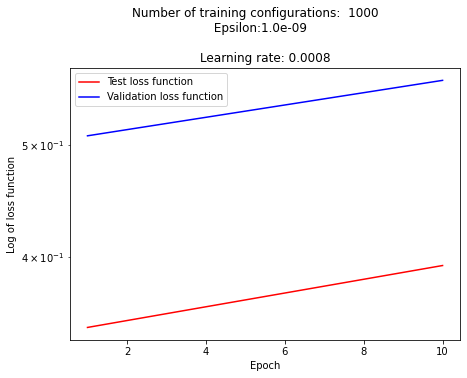

In [24]:
%%time
# ... training loop ...

import torch.optim as optim
from tqdm.notebook import tqdm

EPOCHS = 100
epochs = np.arange(1,EPOCHS+1)


BETAS = (0.9, 0.999)
WEIGHT_DECAY = 0


# GRID SEARCH

learningRates = np.linspace(0.0008,0.08,50)
learnConfigurationNumbers = np.arange(1000,10000,500)
eps=[1e-9,1e-8,1e-7,1e-6]
# betas = ? I am not sure in what range to vary these

NLR = len(learningRates)
NLCN = len(learnConfigurationNumbers)
NE = len(eps)

LOSSES = torch.zeros(NLCN, NLR,NE,EPOCHS)
LossValid = torch.zeros(NLCN, NLR,NE,EPOCHS)

Nconf_valid = 500
phivalid = torch.rand((Nconf_valid,Nt,Nx),**torchTensorArgs).real+1.j*tpOffset 

BigLoss = torch.zeros(NLCN, NLR,NE)

numPRACLLayers = 1
internalLayer = 2

for i in range(NLCN):        # number of training configurations 
    
    Nconf_learn = learnConfigurationNumbers[i]
    phiR = torch.rand((Nconf_learn,Nt,Nx),**torchTensorArgs).real+1.j*tpOffset 
    
    for j in range(NLR):   # learning rate 
        
        LR = learningRates[j]
        
        for k in range(NE): # epsilon 
            
            EPS = eps[k]
            NN = []     # initialise the NN

            for _ in range(numPRACLLayers):
                NN.append(
                    PRCL(
                        Nt,
                        Nx,
                        coupling1 = generate_coupling(internalLayer),
                        coupling2 = generate_coupling(internalLayer),
                    )
                )

            NN = Sequential(NN)
            
            optimizer = optim.Adam(NN.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=WEIGHT_DECAY, amsgrad=False, maximize=True)

            for epoch in tqdm(range(EPOCHS)):   

                phiM, logDetJ_NN = NN(phiR)
                loss = Loss(phiM, logDetJ_NN)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                LOSSES[i][j][k][epoch] = loss
                
                if epoch % 10 == 0 and epoch != 0:
                    PATH = f"NN, Nconf is {Nconf_learn}, learning rate is {LR}, epsilon is {EPS}, {epoch} epochs.pdf"
                    torch.save(NN.state_dict(), PATH)


                # validation
                with torch.no_grad():
                    PHIvalid, logD = NN(phivalid)
                    LossValid[i][j][k][epoch] = Loss(PHIvalid, logD)
                    
            BigLoss[i][j][k] = loss.item()
            
            #plotting

            fig = plt.figure(figsize=(7,5))
            plt.plot(epochs, LOSSES[i][j][k].detach().numpy(),  '-r', label='Test loss function')
            plt.yscale('log')
            plt.xlabel('Epoch')
            plt.ylabel('Log of loss function')

            plt.plot(epochs, LossValid[i][j][k].numpy(), '-b', label='Validation loss function')
            plt.legend()

            plt.title('Learning rate: %.4f'%(LR))
            plt.suptitle('Number of training configurations:  %.0f  \n Epsilon:%.1e'%(Nconf_learn, EPS), y=1.05)
            plt.savefig(f"Loss fn plot, Nconf is {Nconf_learn}, learning rate is {LR}, epsilon is {EPS}.jpg",bbox_inches='tight', dpi=150)
            #plt.show()

